# Image Segmentation Models: Baseline Training and Predictions

Notebook adapted from [Dr. Sreenivas Bhattiprolu](https://github.com/bnsreenu/python_for_microscopists/tree/master/228_semantic_segmentation_of_aerial_imagery_using_unet)

Working GPU support for training is strongly recommended!

In [ ]:
# Install all dependencies from requirements file
!pip install -r requirements.txt

In [ ]:
# Dependencies
!pip install keras==2.3.1
!pip install tensorflow==2.1.0
!pip install keras_applications==1.0.8
!pip install image-classifiers==1.0.0
!pip install efficientnet==1.0.0

In [ ]:
!pip install -U segmentation-models

In [3]:
# The above dependencies might result in a conflict with newer Python versions (AttributeError: 'str' object has no attribute 'decode'). 
# In that case replace the saving.py file in the keras engine with the fixed file from the repository.
#!cp data/saving.py /usr/local/lib/python3.7/dist-packages/keras/engine/

In [4]:
import os
import cv2
import numpy as np
import random
import pickle
import time 
import gc
from datetime import date, datetime

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from PIL import Image

import segmentation_models as sm
#from tensorflow.keras.metrics import MeanIoU
from keras.metrics import MeanIoU
from keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

Using TensorFlow backend.


Segmentation Models: using `keras` framework.
/content/drive/MyDrive/Trustbit/U-Net-YT


In [ ]:
# Set working directory if necessary
#%cd /content/drive/MyDrive/Trustbit/U-Net-YT

# SPECIFY IMAGE SIZE
patch_size = 480

In [ ]:
# Check GPU connection
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

## Load custom data into memory for predictions

In [ ]:
# Load custom data
image_dataset = []  
image_name_ls = []

path = "custom/path"

images = os.listdir(path)  #List of all image names in this subdirectory
images.sort()


for i in images:
    image = cv2.imread(path+"/"+i, 1)  #Read each image as BGR
    
    image = Image.fromarray(image)                                      ##### PSPNet
    image = image.resize((480, 480))

    image = np.array(image)
    
    img = scaler.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape)
            
    image_dataset.append(img)

X_test = image_dataset

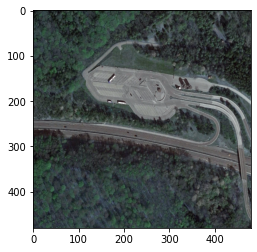

In [ ]:
# Check images
rnr = random.randint(0, len(X_test))
print(rnr)
plt.imshow(X_test[rnr])
plt.show()

## Load images in memory for training

In [ ]:
# SPECIFY DATA PATH
# Must contain raw images and masks!
path = "data/training_data_Mask"

In [5]:
# Read images from respective directory

# SPECIFY MAX NUMBER OF IMAGES THAT SHOULD BE LOADED (must be even)
max_images = 400

if max_images % 2 != 0:
    raise ValueError("Max number of images (max_images) must be even!")

    
image_dataset = []  
mask_dataset = []
image_ids = []
mask_name_ls = []
counter = 0

images = os.listdir(path)  # List of all image names in this subdirectory
images.sort()
images = [i for i in images if not i.startswith(".")]

for i, image_name in enumerate(images):
    if counter >= max_images:  
        if len(image_dataset) == len(mask_dataset):
            break

    if image_name.endswith(".jpeg") and image_name.startswith("T"):   # Only read truck and jpg images
        image = cv2.imread(path+"/"+image_name, 1)  # Read each image as BGR

        #image = image.crop((0 ,0, 480, 480))  # Crop from top left corner
        #image = image.resize((480, 480))      # Resize image, try not to use
        image = np.array(image)
        
        img = scaler.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape)
                
        image_dataset.append(img)
        image_ids.append(image_name)

    elif image_name.endswith("MASK.png") and image_name.startswith("T"): # Load mask
        mask = cv2.imread(path+"/"+image_name, 1)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
        #mask = mask.crop((0 ,0, 480, 480))  # Crop from top left corner
        #mask = mask.resize((480, 480))      # Resize image, try not to use
        mask = np.array(mask)   

        mask_dataset.append(mask)
        mask_name_ls.append(image_name)

        counter += 1

Images: 400


In [ ]:
"""
# Add the class "car parking lot"
# SPECIFY MAX NUMBER OF CAR IMAGES THAT SHOULD BE LOADED (must be odd)
max_images_car = 399

if max_images_car % 2 != 1:
    raise ValueError("Max number of images must be odd!")

counter = 0
for i, image_name in enumerate(images):
    if counter > max_images_car:
        if len(image_dataset) == len(mask_dataset):
            break

    if image_name.endswith(".jpeg") and image_name.startswith("C"):   #Only read car and jpg images
        image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR

        #image = image.crop((0 ,0, 480, 480))  # Crop from top left corner
        #image = image.resize((480, 480))      # Resize image, try not to use
        image = np.array(image)
        
        img = scaler.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape)
                
        image_dataset.append(img)
        image_name_ls.append(image_name)

    elif image_name.endswith("MASK.png") and image_name.startswith("C"):
        mask = cv2.imread(path+"/"+image_name, 1)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
        #mask = mask.crop((0 ,0, 480, 480))  # Crop from top left corner
        #mask = mask.resize((480, 480))      # Resize image, try not to use
        mask = np.array(mask)   

        mask_dataset.append(mask)
        mask_name_ls.append(image_name)

        counter += 1
"""

In [ ]:
# Transform lists to numpy arrays and check if lengths are identical
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

if len(image_dataset) != len(mask_dataset):
    print("ERROR: Lengths differ!")
else:
    print("Nr. of images loaded:", len(image_dataset))

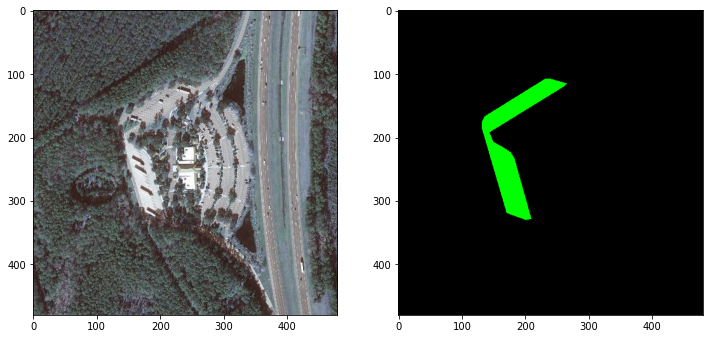

In [ ]:
# Sanity check: Images loaded correct? Mask fits to image?
image_number = random.randint(0, len(image_dataset))
#image_number = 3
print(image_number, "=", image_ids[image_number])

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

## Image processing

In [6]:
# Now replace RGB to integer values to be used as labels.
# Find pixels with combination of RGB for the above defined arrays...
# if matches then replace all values in that pixel with a specific integer
background =    np.array([0, 0, 0])
truck_parking = np.array((0, 255, 0))
car_parking =   np.array((0, 0, 255))

def rgb_to_2D_label(label):
    
    #Supply our labale masks as input in RGB format. 
    #Replace pixels with specific RGB values ...

    label_seg = np.zeros(label.shape, dtype=np.uint8)
    label_seg[np.all(label==background, axis=-1)] = 0
    label_seg[np.all(label==truck_parking, axis=-1)] = 1 # Trucks
    label_seg[np.all(label==car_parking, axis=-1)] = 2   # Cars
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)

# Check if there are only as many entries as classes + 1 (background)
print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1]


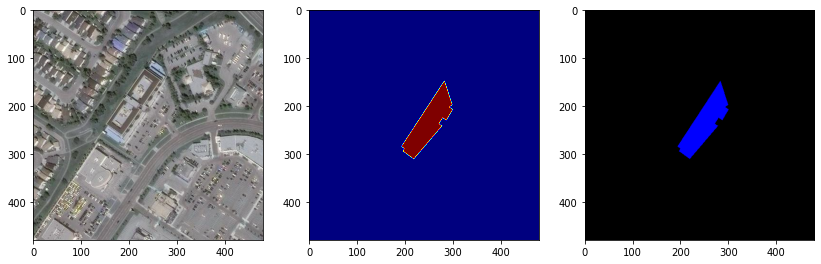

In [ ]:
# Another Sanity check: Are labels and masks correctly assigned to image and class?
image_number = random.randint(0, len(image_dataset)-1)
#image_number = 0
print(image_number, "=", image_ids[image_number])

plt.figure(figsize=(14, 8))
plt.subplot(131)
plt.imshow(image_dataset[image_number])
plt.subplot(132)
plt.imshow(labels[image_number][:,:,0], cmap='jet')
plt.subplot(133)
plt.imshow(mask_dataset[image_number])
plt.show()

## Train-Test-Split

In [ ]:
# CAUTION: This process will delete the old lists to free up memory
n_classes = len(np.unique(labels))

# Free up memory
del images
del mask_dataset 
del mask_name_ls 
gc.collect()

# Change labels to categories
labels_cat = to_categorical(labels, num_classes=n_classes)
del labels # Free up memory
gc.collect()

0

In [ ]:
# Create validation set beforehand
image_dataset, X_val, labels_cat, y_val = train_test_split(image_dataset, labels_cat, test_size = 0.10, random_state = 101)

In [ ]:
# Create Train and test set
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)
#_, X_test, _, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

# Free up memory
del image_dataset
gc.collect()

## Augmentation of train data set

In [ ]:
# Augmentation

# SPECIFY MAX NUMBER OF IMAGES THAT SHOULD BE AUGMENTED 
# In current implementation must be smaller than the length of X_train!
max_images = 40

if max_images > len(X_train):
    raise ValueError("max_images must lower than length of X_train!")

X_train_temp = []
y_train_temp =  []
counter = max_images + len(X_train)

np.random.seed(101)

for i in range(len(X_train)):
    if len(X_train_temp) != len(y_train_temp):
        print("Error: Lengths of X and y train lists differ! Job aborted.")
        break
        
    if len(X_train_temp) >= counter:  
        break

    img = X_train[i]
    mask = y_train[i]

    X_train_temp.append(img)
    y_train_temp.append(mask)

    # 90 degree rotation
    angle = np.random.randint(0,4)

    img_aug = np.rot90(img, angle)

    mask_aug = np.rot90(mask, angle)

    #X_train_temp.append(img_aug)
    #y_train_temp.append(mask_aug)


    if np.random.randint(0,101) > 50: # SPECIFIY PROBABILITY OF VERTICAL FLIP
        # vertical flip
        img_aug2 = np.flip(img_aug, 0)
        mask_aug2 = np.flip(mask_aug, 0)

        X_train_temp.append(img_aug2)
        y_train_temp.append(mask_aug2)

    else:
        # horizonal flip
        img_aug3 = np.flip(img_aug, 1)
        mask_aug3 = np.flip(mask_aug, 1)

        X_train_temp.append(img_aug3)
        y_train_temp.append(mask_aug3)


# Transform lists to numpy arrays and check if lengths are identical
X_train = np.array(X_train_temp)
y_train =  np.array(y_train_temp)

# Free up memory
del X_train_temp
del y_train_temp

# Check if lengths are correct
if len(X_train) != len(y_train):
    print("ERROR: Lengths differ!")
else:
    print("Images:", len(X_train))

In [ ]:
# Sanity check
image_number = random.randint(0, len(X_train)-1)
#image_number = 0
print(image_number, "=", image_ids[image_number])

X_img = X_train[image_number]

y_img = y_train[image_number]
y_img_input = np.expand_dims(y_img, 0)
y_img_input = np.argmax(y_img_input, axis=3)[0,:,:]

plt.figure(figsize=(14, 8))
plt.subplot(121)
plt.imshow(X_img)
plt.subplot(122)
plt.imshow(y_img_input)
plt.show()

## Training

In [8]:
# Set parameters for training the model

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss

# Generate weights automatically
#from sklearn.utils.class_weight import compute_class_weight
#weights = compute_class_weight('balanced', classes=np.unique(np.ravel(labels, order='C')), y=np.ravel(labels, order='C'))
#print("weights:", weights)

# OR MANUALLY SPECIFY WEIGTHS ACCORDING TO NUMBER OF CLASSES
#weights = [1/3, 1/3, 1/3]
weights = [0.5, 0.5]

# Specifiy loss function(s)
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# Specify image dimensions
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

### Training with standard U-Net implementation

In [ ]:
from simple_multi_unet_model import multi_unet_model, jacard_coef  
metrics=['accuracy', jacard_coef] # Define metrics shown

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
#model.summary()

In [ ]:
# Fit Model
date_model = date.today().strftime("%b-%d-%Y")
time_model = datetime.now().strftime("%H:%M")

history1 = model.fit(X_train, y_train,
                    batch_size=16,
                    verbose=1,
                    epochs=30,
                    validation_data=(X_test, y_test),
                    shuffle=False)

In [ ]:
# Save model
full_date = date_model + "-" + time_model
full_date = full_date.replace(":", "")
 
model.save(f"models/unet_{full_date}.hdf5")
print(f"unet_{full_date}.hdf5"")

### Training with Segmentation-Models API

In [ ]:
from simple_multi_unet_model import jacard_coef  
metrics=['accuracy', jacard_coef, sm.metrics.IOUScore(), sm.metrics.FScore(), sm.metrics.Precision(), sm.metrics.Recall()] # Define metrics shown

#SPECIFY BACKBONE (WITH PRETRAINED WEIGHTS ON IMAGNET)
BACKBONE = 'resnet50'  
#BACKBONE = "resnet152" # "senet154", "resnet34", 'efficientnetb4', "inceptionv3", resnet101, resnet152
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

activation = 'sigmoid' if n_classes == 1 else 'softmax' # softmax or sigmoid for 1 class

# DEFINE MODEL
# https://segmentation-models.readthedocs.io/en/latest/api.html
# https://github.com/qubvel/segmentation_models
#model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation=activation) 
#model_resnet_backbone = sm.Linknet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation=activation) 
#model_resnet_backbone = sm.FPN(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation=activation) 
model_resnet_backbone = sm.PSPNet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation=activation, input_shape=(480, 480, 3)) 


# compile keras model with defined optimizer, loss and metrics
#model_resnet_backbone.compile(optimizer='adam', loss=focal_loss, metrics=metrics)
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

#print(model_resnet_backbone.summary())

In [ ]:
# Fit Model
date_model = date.today().strftime("%b-%d-%Y")
time_model = datetime.now().strftime("%H:%M")

start_time = time.localtime()
start_t = time.time()
print("Started at:", time.asctime(start_time))

# Cf. https://keras.rstudio.com/reference/fit.html
history = model_resnet_backbone.fit(X_train_prepr,
                                     y_train,
                                     batch_size=6,
                                     #steps_per_epoch=len(X_train_prepr),
                                     #validation_steps=5, 
                                     epochs=30,
                                     verbose=1,
                                     validation_data=(X_test_prepr, y_test))

"""
# Can be used for fine-tuning (however not working yet)
# Cf. https://segmentation-models.readthedocs.io/en/latest/tutorial.html#fine-tuning

sm.utils.set_trainable(model_resnet_backbone, recompile=True)
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

history = model_resnet_backbone.fit(X_train_prepr,
                                     y_train,
                                     batch_size=6,
                                     #steps_per_epoch=len(X_train_prepr),
                                     #validation_steps=5, 
                                     epochs=28,
                                     verbose=1,
                                     validation_data=(X_test_prepr, y_test))
"""

end_t = time.time()
print("Computation time (Min.):", (end_t-start_t)/60)

model = model_resnet_backbone
history = history.history

Started at: Wed Jun 22 18:25:13 2022
Train on 320 samples, validate on 80 samples
Epoch 1/30
320/320 [==============================] - 23s 71ms/step - loss: 0.3194 - accuracy: 0.9247 - jacard_coef: 0.8322 - iou_score: 0.4873 - f1-score: 0.5380 - precision: 0.5511 - recall: 0.5468 - val_loss: 0.7767 - val_accuracy: 0.9518 - val_jacard_coef: 0.9083 - val_iou_score: 0.4759 - val_f1-score: 0.4876 - val_precision: 0.9759 - val_recall: 0.5000
Epoch 2/30
320/320 [==============================] - 16s 49ms/step - loss: 0.1328 - accuracy: 0.9529 - jacard_coef: 0.8726 - iou_score: 0.5586 - f1-score: 0.6381 - precision: 0.6420 - recall: 0.6437 - val_loss: 0.1943 - val_accuracy: 0.9518 - val_jacard_coef: 0.8958 - val_iou_score: 0.4842 - val_f1-score: 0.5088 - val_precision: 0.5458 - val_recall: 0.5096
Epoch 3/30
320/320 [==============================] - 16s 49ms/step - loss: 0.1130 - accuracy: 0.9560 - jacard_coef: 0.8827 - iou_score: 0.5812 - f1-score: 0.6662 - precision: 0.6704 - recall: 0.673

In [ ]:
# Save model
full_date = date_model + "-" + time_model
full_date = full_date.replace(":", "")
 
# SPECIFIY MODEL NAME
model_name = f"PSPNet_sm_{full_date}"

model_resnet_backbone.save(f"models/{model_name}.hdf5")

with open(f"models/{model_name}-history.ob", 'wb') as fp:
    pickle.dump(history, fp)

print(f"{model_name}")

M513-PSPNet_sm_Jun-13-2022-1924


## Start from checkpoint

In [9]:
# SPECIFY MODEL THAT SHOULD BE LOADED
model_name = "M50-PSPNet_sm_Jun-11-2022-1244"

model = load_model(f"models/{model_name}.hdf5", compile=False)

with open (f"models/{model_name}-history.ob", 'rb') as fp:
    history = pickle.load(fp)

## Get evaluation metrics

In [10]:
# Cf. https://github.com/qubvel/segmentation_models/blob/master/segmentation_models/metrics.py
# & https://github.com/qubvel/segmentation_models/blob/master/segmentation_models/base/functional.py
loss = history['loss'][-1]
val_loss = history['val_loss'][-1]

val_accuracy =  history['val_accuracy'][-1]
val_jacard =    history['val_jacard_coef'][-1]
val_iou_score = history['val_iou_score'][-1]
val_f1_score =  history['val_f1-score'][-1]
val_precision = history['val_precision'][-1]
val_recall =    history['val_recall'][-1]

print("Loss:          ", loss)
print("Val_Loss:      ", val_loss)
print("")
print("Val_jacard:    ", val_jacard)    # = IoU
print("")
print("Val_iou_score: ", val_iou_score)
print("Val_accuracy:  ", val_accuracy)
print("Val_f1_score:  ", val_f1_score)  # Dice coef
print("Val_precision: ", val_precision)
print("Val_recall:    ", val_recall)

Loss:           0.012634846242144704
Val_Loss:       0.1557932011783123

Val_jacard:     0.9350364804267883

Val_iou_score:  0.6846674680709839
Val_accuracy:   0.9683701395988464
Val_f1_score:   0.7740553617477417
Val_precision:  0.8812555074691772
Val_recall:     0.7212663888931274


## Plot training and validation accuracy and loss at each epoch

In [ ]:
##plot the training and validation accuracy and loss at each epoch
metrics = ["loss", "jacard_coef", "iou_score", "f1-score", "precision", "recall"]
metric = metrics[2] # IoU

loss = history[metric]
val_loss = history[f"val_{metric}"]

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12,8))

plt.plot(epochs, loss, 'y', label=f'Training {metric}')
plt.plot(epochs, val_loss, 'r', label=f'Validation {metric}')

plt.title(f'Training and validation {metric}')
plt.xlabel('Epochs')
plt.ylabel(metric)
plt.legend()

# SAVE GRAPH IF NEEDED
#plt.savefig(f'Train_History_Img/history_{metric}-PSPNET.png')

plt.show()

## Predictions

In [ ]:
# Evaluation
# https://github.com/qubvel/segmentation_models/blob/master/examples/multiclass%20segmentation%20(camvid).ipynb
# https://segmentation-models.readthedocs.io/en/latest/api.html
# https://www.kaggle.com/code/animeshganai/notebooka5d51c716d

In [11]:
# Get predictions
y_pred = model.predict(X_test) # Alternatively with X_val

y_pred_argmax = np.argmax(y_pred, axis=3) 
y_test_argmax = np.argmax(y_test, axis=3) # Alternatively with y_val

# Using built in keras function for IoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.71610445


In [ ]:
# Predict on a random image
test_img_number = random.randint(0, len(X_test))

test_img = X_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)

prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

plt.figure(figsize=(10, 10))

plt.title('Prediction')
plt.imshow(test_img)

col_a = np.array([(0.1, 0.2, 0.5, 0), "red"], dtype=object)
cmap_c = ListedColormap(col_a)

plt.imshow(predicted_img, cmap=cmap_c, alpha=0.23)

plt.show()

In [ ]:
# Get several predicted images
id_from = 10

id_to = 20 #len(X_test)

col_a = np.array([(0.1, 0.2, 0.5, 0), "red"], dtype=object)
cmap_c = ListedColormap(col_a)

for i in range(id_from, id_to):
    test_img = X_test[i]
    test_img_input = np.expand_dims(test_img, 0)

    prediction = (model.predict(test_img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:]

    plt.figure(figsize=(10, 10))

    plt.title('Prediction')
    plt.imshow(test_img)

    plt.imshow(predicted_img, cmap=cmap_c, alpha=0.2)

    plt.show()